# System Identification by Lennart Ljung

In this Jupyter Notebook we will discover the ideas of System Identification. The Notebook is written by following along the book System Identification by Lennart Ljung (1st edition). Here, we will learn the knowledge needed in order to be able to apply system identification in real life. The book will be followed chronologically and Python is utilized to clarify some of the ideas.

# Chapter 1

## Descriptions of dynamical system

For starters we want to develop properties between the input to a system and the output of a system. In general, for linear time-invariant and casual systems, where we assume the input is constant over a sampling period T, the output can be fully characterized by its impulse response 

$y(t) = \sum_{k=0}^{\infty}g(k)u(t-k), \quad t = 0,1,2,\dots$

Where we use t to enumerate the sampling instants. Obviously, k does not naturally go to infinity, but is usually finite. Let us discover through an example. Normally we do not know what g(k) is, but for illustration purposes, we can assume a system for now. Let us suppose:

$g(0) = 0 \\ $
$g(1) = 1 \\ $ 
$g(2) = 2 \\ $
$g(3) = 0 \\ $
$g(4) = 1 \\ $
$g(k) = 0, \quad k>4$

We let g(0) = 0 since we don't really have "direct transmission" from an input to an output when it comes to dynamical systems (usually). With this information, we can simulate the system response $y(t)$ for any arbitrary input sequence $u(t)$. 

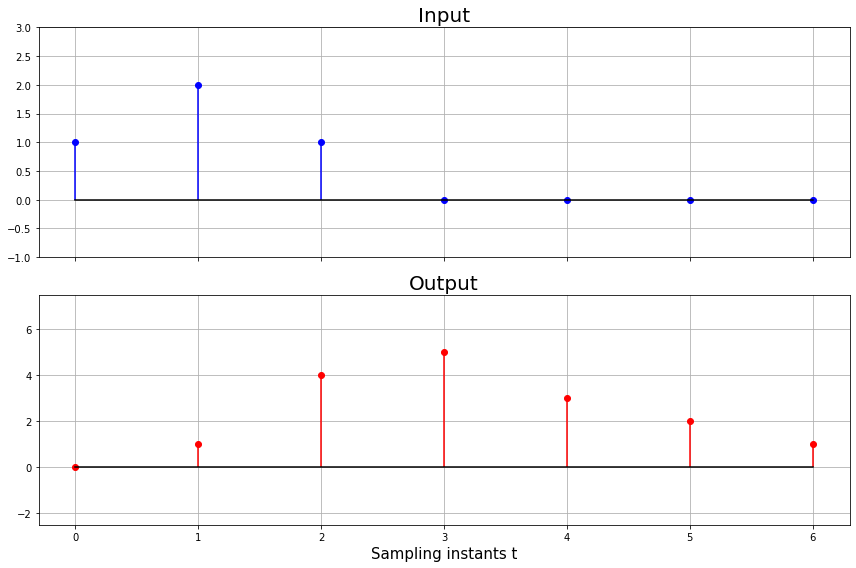

In [20]:
import numpy as np 
import matplotlib.pyplot as plt #for plots

g = np.array([0, 1, 2, 0, 1])
u = np.array([1,2,1]) #change to arbitrary input

def impulse_response(g,u):
    #calculate the impulse response based on definition 
    #page 15 eq. 2.6 (convolution)
    
    len_g = len(g)
    len_u = len(u)
    
    y = []
    for i in range(len_g+len_u-1):
        y_temp = 0
        for k in range(len_g): 
            if (i-k>=0) & (i-k <= len_u-1):
                y_temp += g[k]*u[i-k]
        y.append(y_temp)
        
    #Testing another way. I'm trying to code the convolution from scratch. 
    #The above is problematic in the sense of having to loop over a list without a corresponding index. 
    #Below code is cleaner.
    
    y = [0] * (len(g) + len(u) - 1) #array of zeros of appropiate length
    for i, ui in enumerate(u): #i is index and ui is u[i]
        for k, gk in enumerate(g): #k is index and gk is g[k]
            y[i + k] += ui * gk 

    return y

y = impulse_response(g,u) #get response

#The above function impulse_response(g,u) may be calculated using vectorized functions from Numpy
#We use assert() to check if something we expect to be true (or false) is not. Great way to debug code.
assert(np.array_equal(impulse_response(g,u),np.convolve(g,u))) #check if impulse_response is same as np.convolve

#Let's pad the u vector with zeros so that it has same length as output. Define a modularized function to do that.
def match_lengths(long_vec, in_vec):
    #pad InVec with zeros to match length of LongVec for easier plotting.
    
    len_long_vec = len(long_vec)
    shape = np.shape(in_vec)
    padded_array = np.zeros((len_long_vec))
    padded_array[0:shape[0]] = in_vec
    
    return padded_array

uvec = match_lengths(y,u) #input padded with zeros
timevec = np.linspace(0,len(y)-1,len(y)) #create sampling instants

#Plots
fig, axs = plt.subplots(2,1,figsize=(12,8),sharex=True)

#create list (label, value,color)
plot_data = [ 
    ('Input',uvec, 'blue'),
    ('Output',y,'red')
]

#zip() returns iterator of tuplets (to avoid indexing)
for ax, (label,values,color) in zip(axs, plot_data):
    markerline, stemlines, baseline = ax.stem(timevec, values)
    plt.setp(stemlines,color=color)
    plt.setp(markerline,color=color)
    plt.setp(baseline,color='k')
    ax.set_title(label,fontsize=20)
    ax.margins(y=0.5) 
    ax.grid()

axs[-1].set_xlabel('Sampling instants t',fontsize=15)
plt.tight_layout()
plt.show()
    

The above description of the output of the system is great in an idealized world, but it's almost never true that we have perfect measurement of the output. There can be a myriad of reasons including disturbances and noise which we typically cover when describing dynamic systems. Disturbance could be uncontrolled input to a system such as wind turbulence on a wind turbine and noise could be noisy measurements in a sensor. We can lump these disturbances and noise into an additive term to the output

$y(t) = \sum_{k=0}^{\infty}g(k)u(t-k) + v(t), \quad t = 0,1,2,\dots$

Information about v(t) is usually not known beforehand, but we can make qualified estimations of future disturbances with knowledge of present data. In this sense, we employ a probabilistic framework to describe them. We define

$v(t) = \sum_{k=0}^{\infty}h(k)e(t-k), \quad t = 0,1,2,\dots$

Where e(t) are independent and identically distributed (abbreviated as i.i.d) with certain probability density functions (PDF). For normalization purposes we assume $h(0) = 1$. By changing the probability density function of $e(t)$ we can describe the aforementioned disturbances or noises. 

One way of describing disturbances is in the following manner. Let

$e(t) = 0$, with probability $1-\mu$

$e(t) = r$, with probability $\mu$.

Where r is normally distributed random variable with mean 0 and variance $\gamma$. The manner in which the disturbance/noise acts upon the system will depend on $h(k)$.

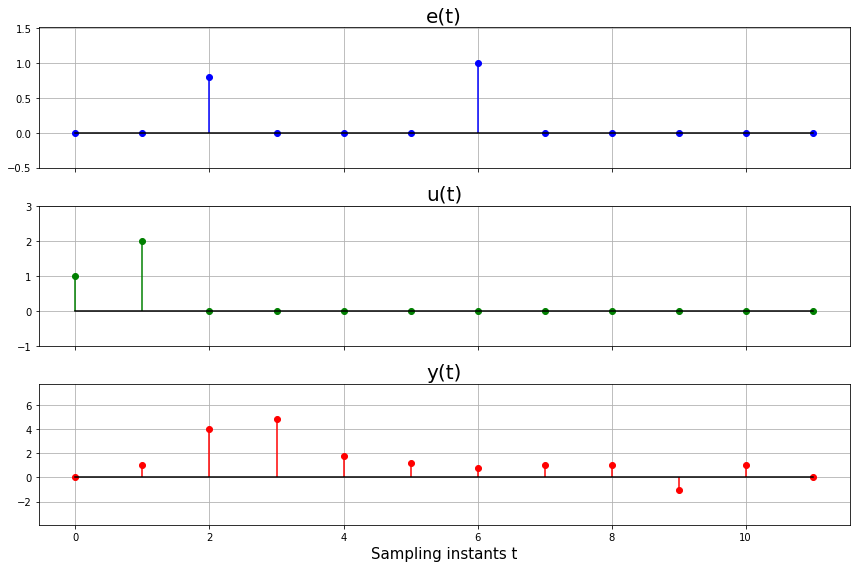

In [3]:
import numpy as np 
import matplotlib.pyplot as plt #for plots

#Create disturbance
gamma = 1 #variance
size_vec = 8 #size of vector
r = np.random.normal(0,np.sqrt(gamma),size=size_vec) #create random vector

mu = 0.15 #probability of disturbance 
draw_from_uniform = np.random.uniform(0,1,size=size_vec) #uniform vector between 0 and 1 
did_r_happen = mu > draw_from_uniform #disturbance happens with probability mu

#Create vectors of inputs and outputs
e = np.where(did_r_happen,r,0) #np.where(condition,value if true, value if false)
h = np.array([1, 1, 1, -1, 1]) #dynamics of how disturbance affects the system
u = np.array([1, 2]) #controlled input
g = np.array([0, 1, 2, 0, 1]) #system dynamics

v = np.convolve(h,e) #convolve disturbance
y_old = np.convolve(g,u) #convolve controlled inputs

def match_lengths(long_vec, in_vec):
    #pad InVec with zeros to match length of LongVec for easier plotting.
    
    len_long_vec = len(long_vec)
    shape = np.shape(in_vec)
    padded_array = np.zeros((len_long_vec))
    padded_array[0:shape[0]] = in_vec
    
    return padded_array

#re-write this to iterate over e,u,v and y_old for match_lengths
longest_vec = max([v,y_old],key=len) #return longest vector of v, y
evec = match_lengths(longest_vec,e) #input padded with zeros
uvec = match_lengths(longest_vec,u) #input padded with zeros
vvec = match_lengths(longest_vec,v) #input padded with zeros
yvec = match_lengths(longest_vec,y_old) #input padded with zeros
y = yvec+vvec #add disturbance and controlled input responses

#plots
timevec = np.linspace(0,len(longest_vec)-1,len(longest_vec)) #create sampling instants
fig, axs = plt.subplots(3,1,figsize=(12,8),sharex=True)

#create list (label, value,color)
plot_data = [ 
    ('e(t)',evec,'blue'),
    ('u(t)',uvec,'green'),
    ('y(t)',y,'red')
]

#zip() returns iterator of tuplest (to avoid indexing)
for ax, (label,values,color) in zip(axs, plot_data):
    markerline, stemlines, baseline = ax.stem(timevec, values)
    plt.setp(stemlines,color=color)
    plt.setp(markerline,color=color)
    plt.setp(baseline,color='k')
    ax.set_title(label,fontsize=20)
    ax.margins(y=0.5) 
    ax.grid()

axs[-1].set_xlabel('Sampling instants t',fontsize=15)
plt.tight_layout()
plt.show()

Another way of describing disturbances as noise is in this manner:

$e(t) \in N(0,\lambda)$

Which merely means that $e(t)$ obeys a gaussian distribution with 0 mean and $\lambda$ variance. This would look something like this:

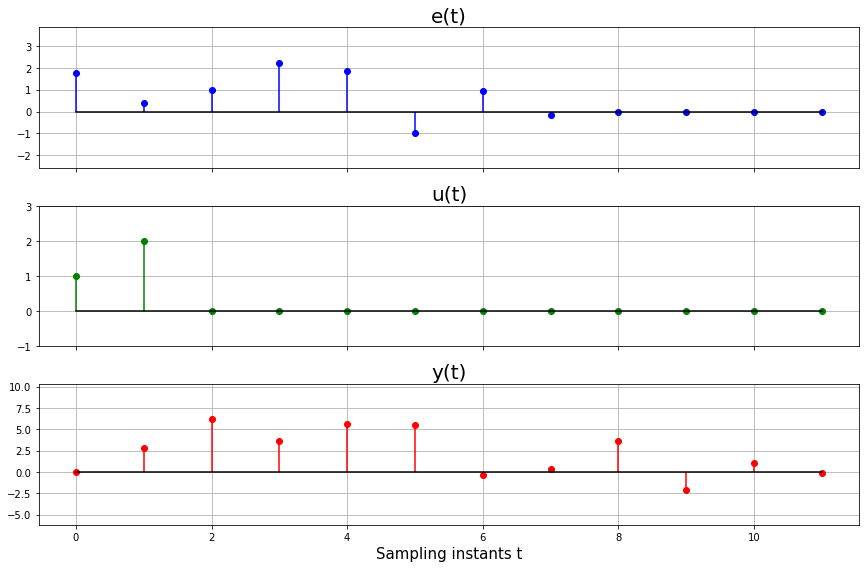

In [15]:
import numpy as np 
import matplotlib.pyplot as plt #for plots

#Create noise
var_lambda = 1 #variance
size_vec = 8 #size of vector

np.random.seed(0) #to recreate results. Use any integer
e = np.random.normal(0,np.sqrt(var_lambda),size=size_vec) #create random vector
h = np.array([1, 1, 1, -1, 1]) #dynamics of how disturbance affects the system
u = np.array([1, 2]) #controlled input
g = np.array([0, 1, 2, 0, 1]) #system dynamics

v = np.convolve(h,e) #convolve disturbance
y_old = np.convolve(g,u) #convolve controlled inputs

def match_lengths(long_vec, in_vec):
    #pad InVec with zeros to match length of LongVec for easier plotting.
    
    len_long_vec = len(long_vec)
    shape = np.shape(in_vec)
    padded_array = np.zeros((len_long_vec))
    padded_array[0:shape[0]] = in_vec
    
    return padded_array

#re-write this to iterate over e,u,v and y_old for match_lengths
longest_vec = max([v,y_old],key=len) #return longest vector of v, y
evec = match_lengths(longest_vec,e) #input padded with zeros
uvec = match_lengths(longest_vec,u) #input padded with zeros
vvec = match_lengths(longest_vec,v) #input padded with zeros
yvec = match_lengths(longest_vec,y_old) #input padded with zeros
y = yvec+vvec #add disturbance and controlled input responses

#plots
timevec = np.linspace(0,len(longest_vec)-1,len(longest_vec)) #create sampling instants
fig, axs = plt.subplots(3,1,figsize=(12,8),sharex=True)

#create list (label, value,color)
plot_data = [ 
    ('e(t)',evec,'blue'),
    ('u(t)',uvec,'green'),
    ('y(t)',y,'red')
]

#zip() returns iterator of tuplest (to avoid indexing)
for ax, (label,values,color) in zip(axs, plot_data):
    markerline, stemlines, baseline = ax.stem(timevec, values)
    plt.setp(stemlines,color=color)
    plt.setp(markerline,color=color)
    plt.setp(baseline,color='k')
    ax.set_title(label,fontsize=20)
    ax.margins(y=0.5) 
    ax.grid()

axs[-1].set_xlabel('Sampling instants t',fontsize=15)
plt.tight_layout()
plt.show()

Here we only show and specify second-order properties of the sequence $e(t)$. The first-order is the mean and the second order is the variance. This is true for both descriptions of $e(t)$ above. Here, $e(t)$ is stochastic which also means that the output $y(t)$ will be stochastic. However, the input $u(t)$ is usually considered the deterministic part of the system. Let us try to analyze analytically the description of $v(t)$ above and find out what we can expect to see in a time-series for different representations. 

## Properties of additive disturbance

# Notes
Nice documentation on various system identification principles and techniques. Nevermind the LABView implementation.
https://documentation.help/NI-SystemIdentification/

Below contains data-set for complex nonlinear systems. 
https://www.nonlinearbenchmark.org/ 

SISO data-set below from the Arduino Temperature Control Lab. Thanks to Bill Tubbs for the suggestion.   
https://apmonitor.com/pdc/uploads/Main/pipeline_data.txt